In [1]:
#goal of this project is to predict which region a specific recipe is coming from
#also to make suggestions of which ingredients to add to an existing list of ingredients
#find similar recipes based on existing sample recipe
#input list of ingredients and predict with which region the resulting taste will be assiciated

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [3]:
with open('srep00196-s3.csv', 'r')  as f:
    raw_df=[]
    for rownum, row in enumerate(f):
        if(rownum<4):
            continue
        row=row.strip().split(',')
        raw_df.append([row[0], ' '.join(row[1:])])

raw_df[0]

['African', 'chicken cinnamon soy_sauce onion ginger']

In [4]:
#subsample dataset
from random import randint
raw_df=[row for row in raw_df if randint(1, 20)==1]
len(raw_df)

2769

In [5]:
df=pd.DataFrame(data=raw_df, columns=['Region', 'Ingredients'])
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2769 entries, 0 to 2768
Data columns (total 2 columns):
Region         2769 non-null object
Ingredients    2769 non-null object
dtypes: object(2)
memory usage: 43.3+ KB


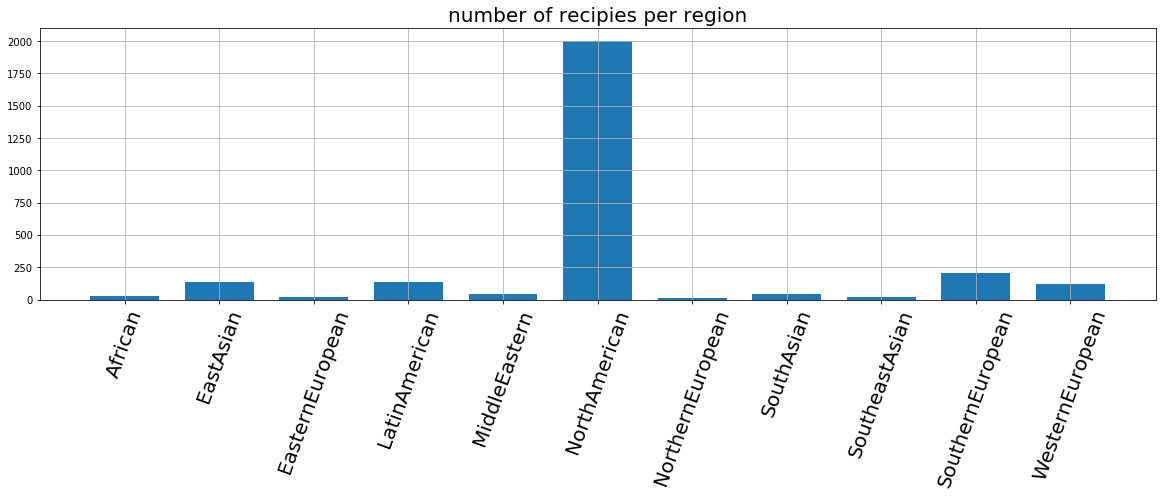

In [6]:
#df=pd.DataFrame(data=raw_df, columns=['Region', 'Ingredients'])
#df.head()

def barplot(ys, labels=[], title=''):
    xs=np.linspace(0, ys.shape[0], ys.shape[0])
    plt.figure(figsize=(20,5))
    plt.bar(xs, ys)
    plt.title(title, fontsize=20)
    plt.xticks(xs, labels, rotation=70, fontsize=20)
    plt.grid()
    plt.show()
    
    
region_count=df.groupby('Region').count()

ys=region_count['Ingredients']
title='number of recipies per region'
labels=region_count.index

barplot(ys, labels, title)

In [7]:
ingredients_per_region=[]

for row in raw_df:
    for ingredient in row[1].split(' '):
        ingredients_per_region.append((row[0], ingredient))
    
df_ingredients_per_region=pd.DataFrame(ingredients_per_region, columns=['Region', 'Ingredient'])
df_ingredients_per_region.head()

top_ingredients=df_ingredients_per_region['Ingredient'].value_counts()[:20]

In [8]:
df_ingredients_per_region['Ingredient'].unique().shape
unique_ingredients_per_region=df_ingredients_per_region.groupby('Region').nunique()

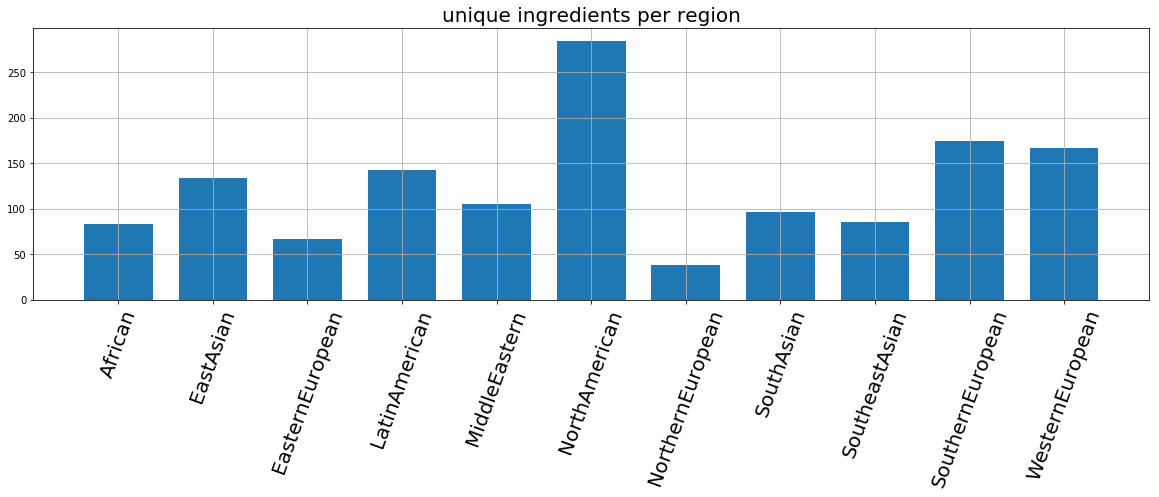

In [9]:
barplot(unique_ingredients_per_region['Ingredient'], region_count.index, 'unique ingredients per region')

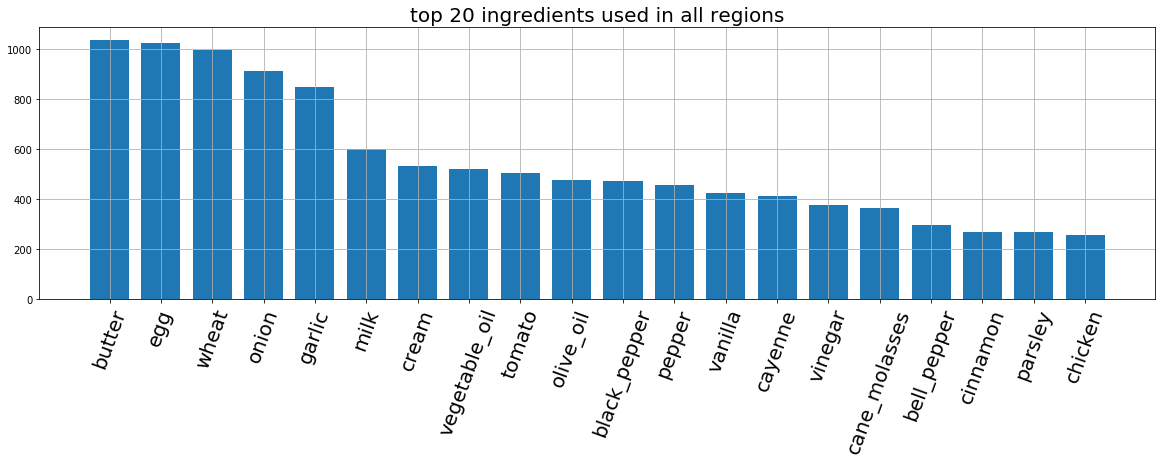

In [10]:
barplot(top_ingredients, top_ingredients.index, 'top 20 ingredients used in all regions')
#top_ingredients

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

cv_ingredients=CountVectorizer()
X_ingredients=cv_ingredients.fit_transform(df['Ingredients'])
ingredients_cv=cv_ingredients.build_analyzer()

cv_regions=CountVectorizer()
y_regions=cv_regions.fit_transform(df['Region'])
regions_cv=cv_regions.build_analyzer()

In [12]:
print(cv_ingredients.get_feature_names()[:5])
#print(X_ingredients.toarray()[:5])

print(cv_regions.get_feature_names()[:5])
#print(y_regions.toarray()[:5])

['almond', 'anise', 'anise_seed', 'apple', 'apricot']
['african', 'eastasian', 'easterneuropean', 'latinamerican', 'middleeastern']


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [14]:
X=X_ingredients.toarray()
y=y_regions.toarray()

region_nums=[]
for row in y:
    region_nums.append(row.tolist().index(1))

region_nums=np.array(region_nums)
df_region_nums=pd.DataFrame(region_nums, columns=['Region'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, df_region_nums['Region'], test_size=0.3, random_state=5)
#X_train.shape, y_train.shape#, df_region_nums.shape

In [16]:
lr=LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
df_region_nums=df_region_nums==1
predicted=lr.predict(X_test)

In [18]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, predicted))
print('Accuracy: ', accuracy_score(y_test, predicted))

             precision    recall  f1-score   support

          0       1.00      0.11      0.20         9
          1       0.71      0.65      0.68        34
          2       0.00      0.00      0.00        15
          3       0.61      0.54      0.57        37
          4       0.00      0.00      0.00        12
          5       0.78      0.94      0.85       595
          6       0.00      0.00      0.00         4
          7       1.00      0.55      0.71        11
          8       0.00      0.00      0.00         3
          9       0.47      0.26      0.34        65
         10       0.00      0.00      0.00        46

avg / total       0.68      0.75      0.70       831

Accuracy:  0.7545126353790613


/home/user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


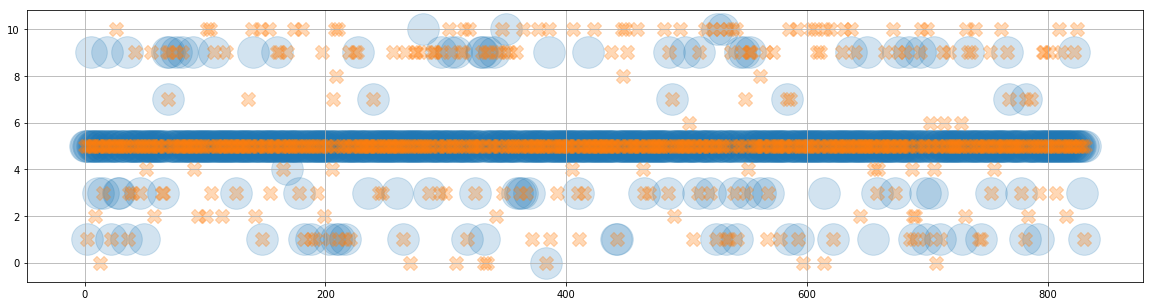

In [19]:
plt.figure(figsize=(20, 5))
plt.grid()
plt.scatter(np.linspace(0, X_test.shape[0], X_test.shape[0]), predicted, alpha=0.2, s=1000)
plt.scatter(np.linspace(0, X_test.shape[0], X_test.shape[0]), y_test, alpha=0.3, marker='X', s=200)
plt.show()

In [20]:
sum(y_test==predicted), sum(y_test!=predicted)

(627, 204)

In [21]:
from sklearn.ensemble import RandomForestClassifier
rnd_forest=RandomForestClassifier()
rnd_forest.fit(X_train, y_train)
rnd_f_predicted=rnd_forest.predict(X_test)

print(classification_report(y_test, rnd_f_predicted))
print('Accuracy: ', accuracy_score(y_test, rnd_f_predicted))

             precision    recall  f1-score   support

          0       0.33      0.11      0.17         9
          1       0.83      0.71      0.76        34
          2       0.00      0.00      0.00        15
          3       0.48      0.43      0.46        37
          4       0.00      0.00      0.00        12
          5       0.77      0.93      0.84       595
          6       0.00      0.00      0.00         4
          7       0.67      0.18      0.29        11
          8       0.00      0.00      0.00         3
          9       0.55      0.32      0.41        65
         10       0.25      0.04      0.07        46

avg / total       0.68      0.74      0.70       831

Accuracy:  0.7436823104693141


/home/user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
cv_ingredients.get_feature_names()

['almond',
 'anise',
 'anise_seed',
 'apple',
 'apricot',
 'armagnac',
 'artemisia',
 'artichoke',
 'asparagus',
 'avocado',
 'bacon',
 'baked_potato',
 'banana',
 'barley',
 'basil',
 'bay',
 'bean',
 'beef',
 'beef_broth',
 'beer',
 'beet',
 'bell_pepper',
 'bergamot',
 'berry',
 'bitter_orange',
 'black_bean',
 'black_currant',
 'black_mustard_seed_oil',
 'black_pepper',
 'black_sesame_seed',
 'black_tea',
 'blackberry',
 'blue_cheese',
 'blueberry',
 'bone_oil',
 'bourbon_whiskey',
 'brandy',
 'brassica',
 'bread',
 'broccoli',
 'brown_rice',
 'brussels_sprout',
 'buckwheat',
 'butter',
 'buttermilk',
 'cabbage',
 'cabernet_sauvignon_wine',
 'cacao',
 'cane_molasses',
 'caraway',
 'cardamom',
 'carnation',
 'carrot',
 'cashew',
 'cassava',
 'catfish',
 'cauliflower',
 'caviar',
 'cayenne',
 'celery',
 'celery_oil',
 'cereal',
 'chamomile',
 'champagne_wine',
 'chayote',
 'cheddar_cheese',
 'cheese',
 'cherry',
 'cherry_brandy',
 'chervil',
 'chicken',
 'chicken_broth',
 'chicken_li

In [30]:
#predict region from ingredients
ingredients='''cane_molasses	ginger	cumin	garlic	tamarind	bread	coriander	vinegar	onion	beef	cayenne	parsley	wheat_bread	yogurt	vegetable_oil	egg
'''.split()

ft_names=cv_ingredients.get_feature_names()
ing_vec=np.zeros(X_train.shape[1])

for ingredient in ingredients:
    idx=ft_names.index(ingredient)
    ing_vec[idx]=1

ing_vec=np.array([ing_vec])
print( X_train.shape, ing_vec.shape)

predicted_lr=lr.predict(ing_vec)
print('LogistReg_prediction: ', cv_regions.get_feature_names()[predicted_lr[0]], predicted_lr)

rnd_f_predicted=rnd_forest.predict(ing_vec)
print('RND_Forest_prediction: ',cv_regions.get_feature_names()[rnd_f_predicted[0]], rnd_f_predicted)

(1938, 318) (1, 318)
LogistReg_predition:  northamerican [5]
RND_Forest_predition:  northamerican [5]
